In [1]:
import matplotlib.pyplot as plt
import itertools, os, copy, random, sys, time, pickle
from functools import partial
from sklearn.decomposition import KernelPCA, PCA, FastICA
from sklearn.cluster import KMeans
from scipy.spatial import KDTree
import matplotlib
import joblib  
from scipy.stats import qmc
import numpy as np
import seaborn as sns
import yaml
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel, ExpSineSquared, RationalQuadratic, Matern, ConstantKernel

In [2]:
import time
import torch
import gpytorch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.variational import VariationalStrategy
from gpytorch.variational import CholeskyVariationalDistribution
from sklearn.metrics import confusion_matrix

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [3]:
from functown import FT

model version:  14:30:36


In [4]:
Q = np.load('rdf02525-025_3T.npy')
C = pd.read_json('50kCwithconditions.json')

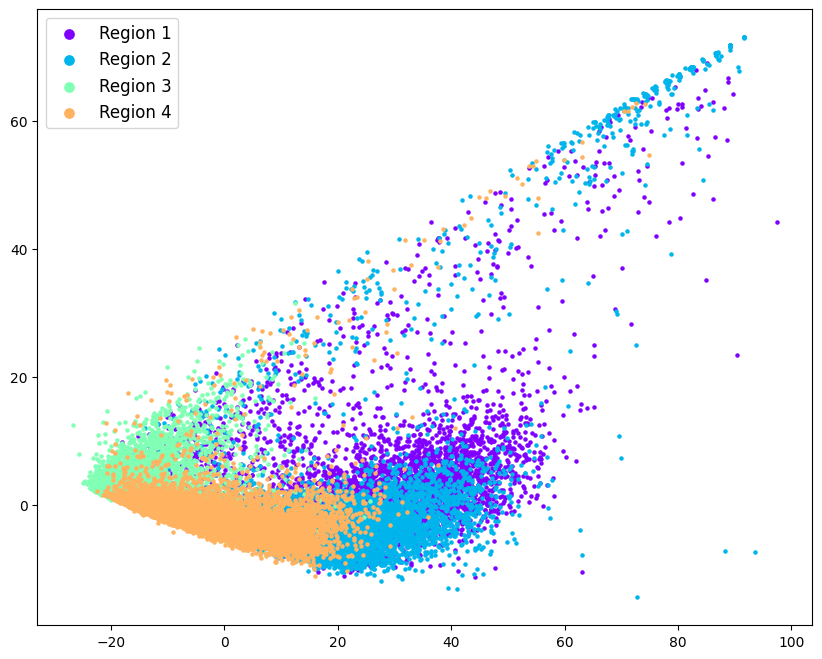

In [5]:
ICM, KM, KL, Q20 = FT.DataToKmean(Q)
FT.PLOTkmean(Q,KL)

{0: 1.625, 1: 2.315, 2: 0.47, 3: 1.375}


,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,...,m,red,w,orange,porosmlr025,influxsmlr2,orfluxsmlr5,rxfinished,newpor,KL
2,0.323708,0.327243,0.329964,0.390397,0.849722,0.787842,0.492757,0.460468,0.660821,0.621880,...,0,161,2198,41,0,0,1,1,0.00000,0
55,0.440564,0.303049,0.336127,0.296994,0.785319,0.803777,0.492518,0.461080,0.604142,0.625192,...,0,155,2199,46,0,0,1,1,0.00000,0
58,0.432953,0.293347,0.533256,0.296800,0.896213,0.781624,0.495485,0.460252,0.458488,0.457490,...,0,125,2199,76,0,0,1,1,0.00000,0
99,0.302970,0.265449,0.435283,0.509054,0.785551,0.700981,0.511653,0.557694,0.457469,0.502015,...,0,179,2199,21,0,0,1,1,0.00000,0
106,0.293198,0.306746,0.360161,0.300771,0.801393,0.480776,0.523683,0.529888,0.456833,0.464182,...,23,144,2198,33,0,0,1,1,0.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49928,0.407398,0.402868,0.524601,0.320598,0.721792,0.472760,0.495394,0.463253,0.456880,0.626161,...,314,124,1952,3,0,0,0,1,0.16667,3
49930,0.294964,0.266171,0.312329,0.463237,0.906797,0.509733,0.711004,0.548767,0.511633,0.514742,...,284,53,2046,3,0,1,0,1,0.14286,3
49933,0.478278,0.269051,0.394474,0.464912,0.564545,0.587592,0.514474,0.472398,0.518351,0.693519,...,446,86,1857,0,0,1,0,1,0.15273,3
49955,0.302083,0.382298,0.483228,0.394504,0.687163,0.546183,0.496819,0.537450,0.467358,0.729448,...,232,111,2037,19,0,0,1,1,0.09000,3


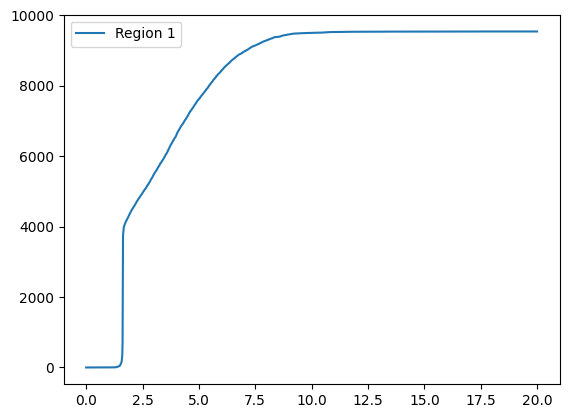

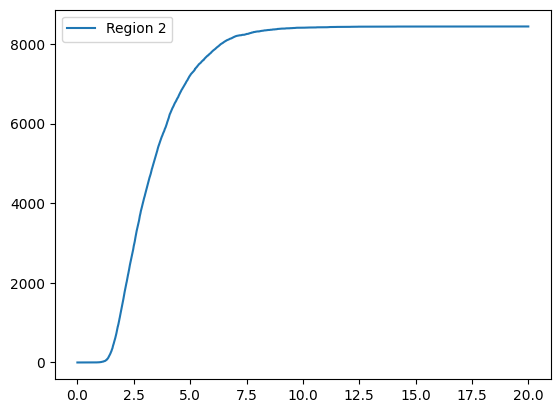

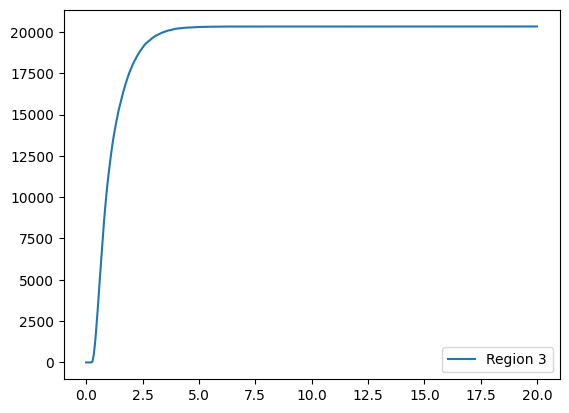

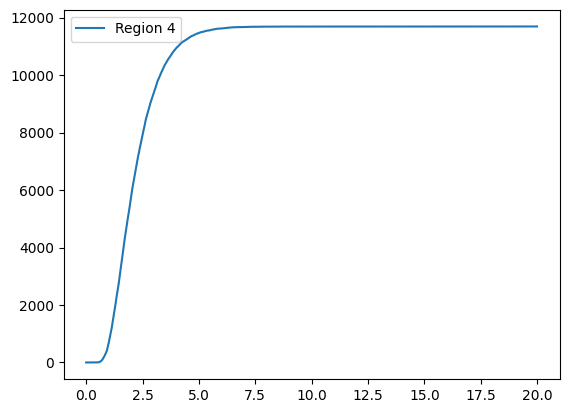

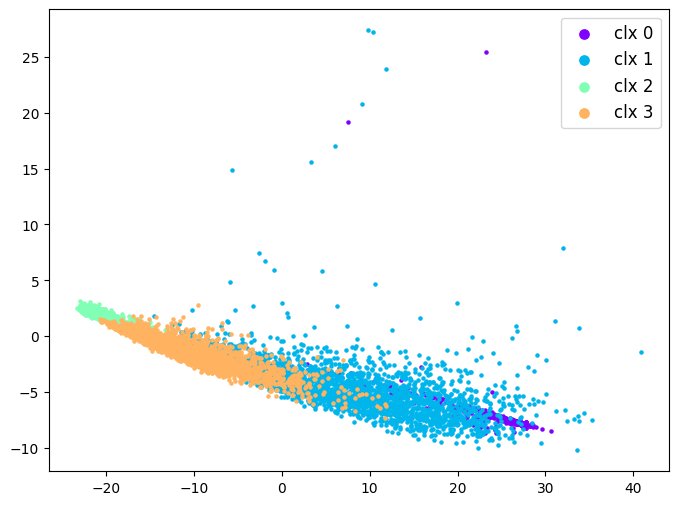

In [11]:
newd, rng, rad = FT.PLOTData(Q20,KM,KL)
Version ={ 1: 600, 2: 1200, 3: 1800, 4: 2400,  5:4000, 'F':5800}
VV = 4
rdic= {}

for i in np.unique(KL):
    try:
        rdic.update({i: np.round( rad[np.where( np.array( rng[i]) < Version[VV] )[0][-1] + 1 ], 3) })
    except:
        rdic.update({i: np.round( rad[np.where( np.array( rng[i]) <Version[VV] )[0][-1]  ], 3) })

print(rdic)

Tdata= FT.DataTrimm(rdic,newd,C,KL, Q)
Tdata

In [8]:
kpca, kpc_res = FT.KernPCA(Tdata)


NameError: name 'Tdata' is not defined

In [ ]:

kpca, kpc_res = FT.KernPCA(Tdata)

G = 10
PO, pp, invN = FT.Space([G], kpca, Tdata.iloc[:,:15])
R = {0: 0, 1:PO[0] - PO[1]*np.log(2), 2:PO[0] + PO[1]*np.log(2), 3:PO[0] + 6*PO[1]*np.log(10)}
sampler = qmc.Sobol(d=15, scramble=True)
sample = sampler.random_base2(m=G)
LOP = 0
a = KDTree(kpc_res)
l_bounds = a.mins - LOP
u_bounds = a.maxes + LOP
pp = qmc.scale(sample, l_bounds, u_bounds)
invN = kpca.inverse_transform(pp)

indx1 = FT.Trx(Tdata.iloc[:,:15], invN, L=[R[0], R[1]])
indx2 = FT.Trx(Tdata.iloc[:,:15], invN, L=[R[1], R[2]])
indx3 = FT.Trx(Tdata.iloc[:,:15], invN, L=[R[2], R[3]])

print(len(indx1), len(indx2), len(indx3))

SPACE = {'stage1': [indx1, 0.35], 'stage2': [indx2, 0.55], 'stage3': [indx3, 0.75]}
m1, lh1 = FT.Mload()
tm2=[]
for i in SPACE:
    _, tm1 = Evaal(m1,lh1,  inputP = invN[SPACE[i][0]]  )
    tm2.append( np.where( np.sum( np.square(tm1), axis=0) < SPACE[i][1])[0]  )
final=[]
for i in tm2:
    for j in i:
        if j not in final:
            final.append(j)
final.sort()
final
PF =pd.DataFrame(invN[final], columns=Tdata.iloc[:,:15].columns )
PF
